In [171]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
file_path = 'MPP_CellTracks_RawValues.xlsx'
df = pd.read_excel(file_path)
df.head(25)

# The first part of the code is on finding the ideal R threshold
# Once we have filtered the data we have to see how you actually 
# parametrize a distribution. 

,x-coordinate (um),y-coordinate (um),z-coordinate (um),Time increment (3-min interval)
0,10.55640,177.909,13.8359,0
1,10.02100,175.347,15.0267,1
2,9.86100,173.524,16.4436,2
3,9.52100,169.617,17.6764,3
4,9.02600,170.557,17.0045,4
5,8.86400,169.753,16.8822,5
6,8.45200,169.870,16.9977,6
7,8.27400,170.066,16.9809,7
8,7.96700,166.800,17.3747,8
9,7.85600,165.343,17.5910,9


In [182]:
#Function to calculate step lengths
# First cell traj goes up to 174 time increments  
def calc_step_length(df):
    df['group_id'] = (df['Time increment (3-min interval)'] == 0).cumsum()  # Create a unique identifier for each trajectory

    df['dx'] = df.groupby('group_id')['x-coordinate (um)'].diff()
    df['dy'] = df.groupby('group_id')['y-coordinate (um)'].diff()
    df['dz'] = df.groupby('group_id')['z-coordinate (um)'].diff()

    df['step_length'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)
    clean_step_length = df['step_length'].dropna()
    step_length = clean_step_length.to_numpy()
    return step_length

In [183]:
def R_filter(steps, R):
    filtered_steps = steps[steps >= R]
    return filtered_steps

In [203]:
# Approximation to kernel density estimator for the distribution (makeshift)
def sample_steps(in_steps, n_samples, bins=500):
    out = np.zeros(n_samples)
    probs, vals = np.histogram(in_steps, bins=bins, range=(0.72, in_steps.max()))
    probs = probs / np.sum(probs)
    for n in range(n_samples):
        bin_idx = np.nonzero(np.random.multinomial(1, probs))[0]
        low = vals[bin_idx - 1]
        high = vals[bin_idx]
        out[n] = np.random.uniform(low, high)
    return out

8034
7137


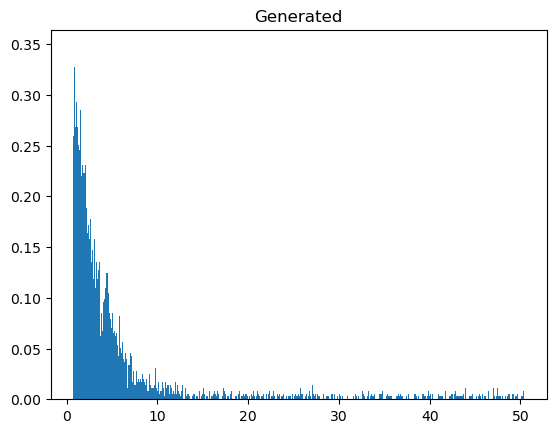

array([17.71371915,  1.37954835,  1.35627867,  6.03296677,  1.1347696 ,
        0.88451509,  1.3576292 ,  3.6376603 ,  4.68292137,  9.15380613])

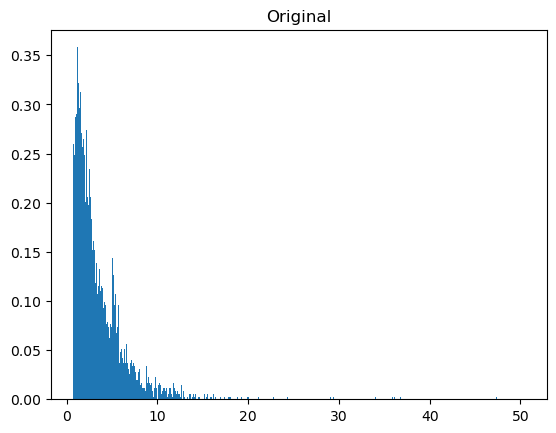

In [206]:
steps = calc_step_length(df)
filtered_steps = R_filter(steps, 0.72)
print(len(steps))
print(len(filtered_steps))
plt.hist(sample_steps(filtered_steps, len(filtered_steps), bins=100), density=True, bins=1000)
plt.title('Generated')
plt.show()
plt.hist(filtered_steps, density=True, bins=1000)
plt.title('Original')
ss = sample_steps(filtered_steps, 10)
ss

In [207]:
filtered_steps.max()

50.41326688124863

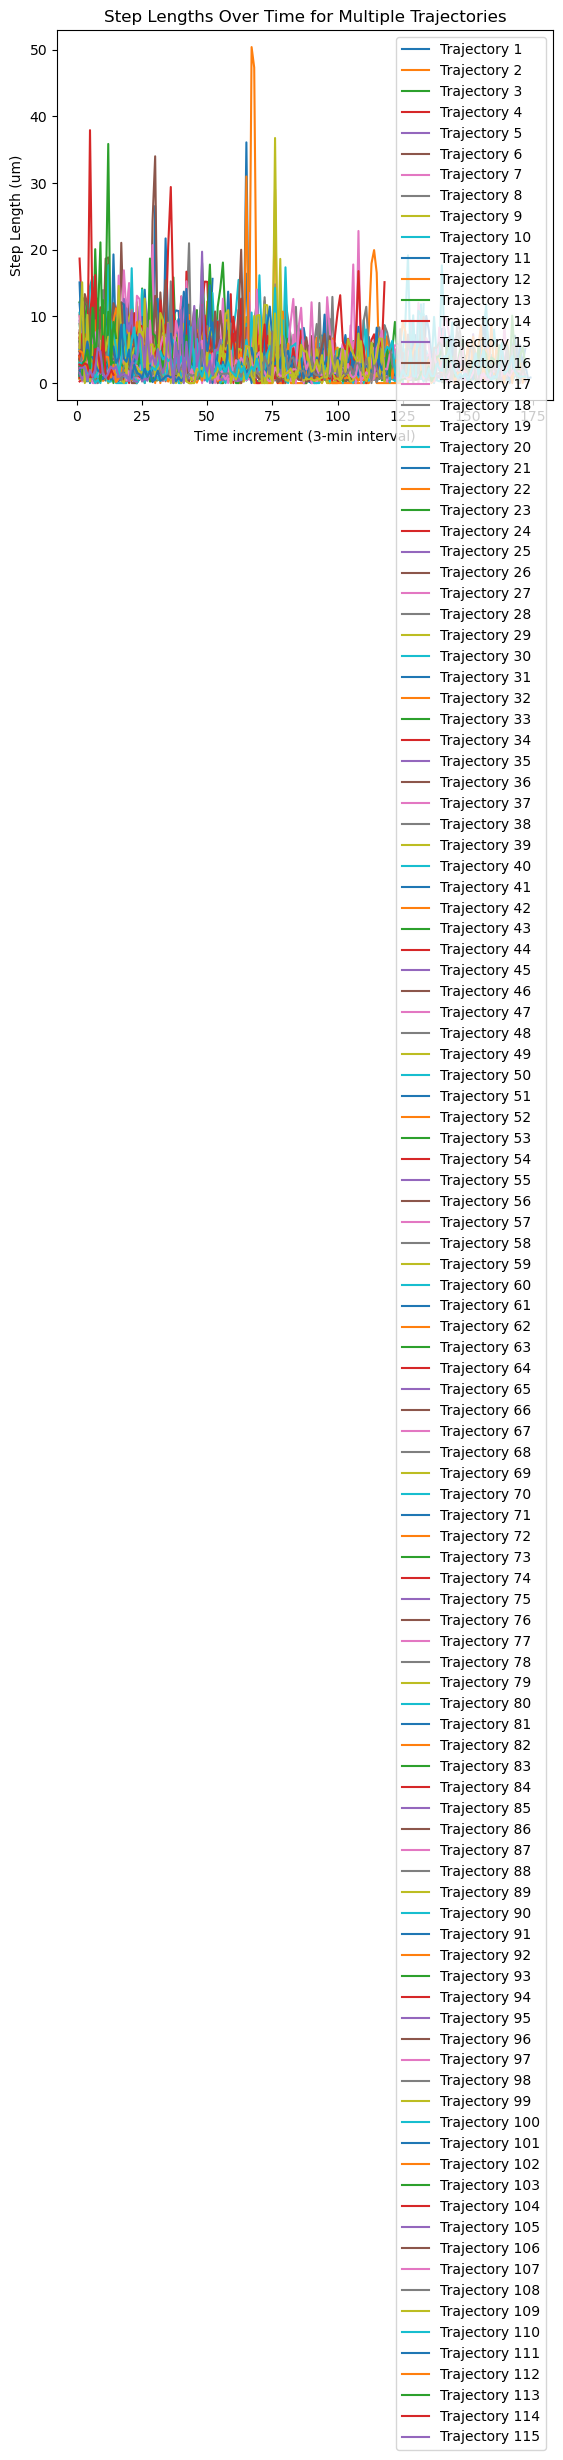

In [143]:
# This graph shows the steps size per trajectory 
# might use it to remove outliers 
for name, group in df.groupby('group_id'):
    plt.plot(group['Time increment (3-min interval)'], group['step_length'], label=f'Trajectory {name}')
    
plt.xlabel('Time increment (3-min interval)')
plt.ylabel('Step Length (um)')
plt.title('Step Lengths Over Time for Multiple Trajectories')
plt.legend()
plt.show()


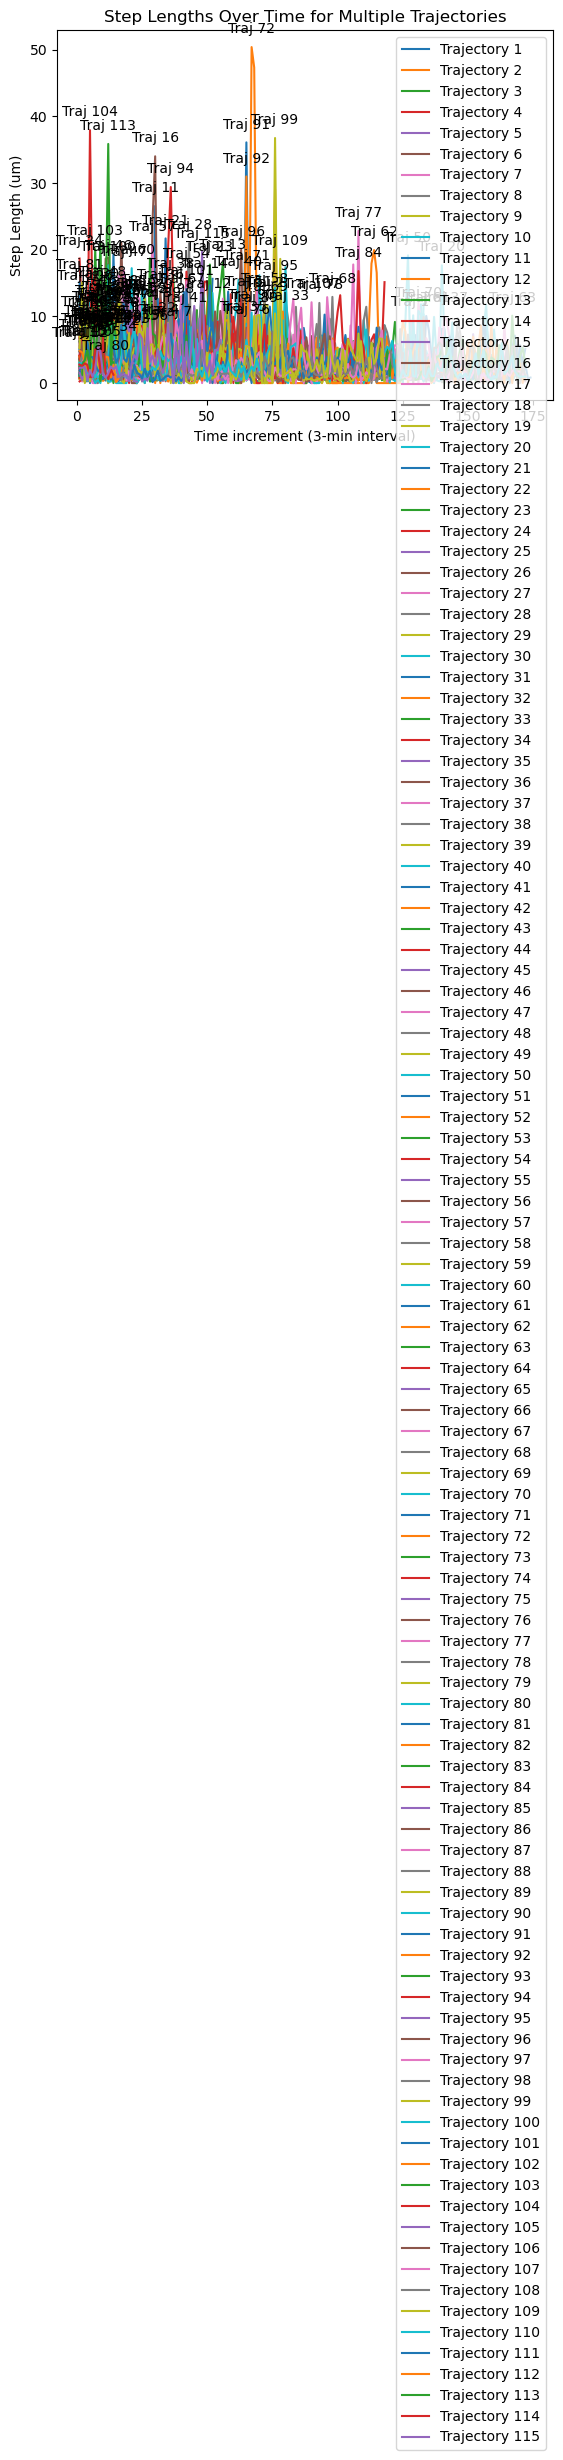

In [146]:
## Anotated version

for name, group in df.groupby('group_id'):
    plt.plot(group['Time increment (3-min interval)'], group['step_length'], label=f'Trajectory {name}')
    max_idx = group['step_length'].idxmax()
    plt.annotate(f'Traj {name}', 
                 (group.loc[max_idx, 'Time increment (3-min interval)'], group.loc[max_idx, 'step_length']),
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Time increment (3-min interval)')
plt.ylabel('Step Length (um)')
plt.title('Step Lengths Over Time for Multiple Trajectories')
plt.legend()
plt.show()